In [129]:
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [142]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

### Zmiana typu kolumn numerycznych na INT64

In [143]:
cols_to_convert = ['Time_spent_Alone', 'Social_event_attendance','Going_outside',  'Friends_circle_size','Post_frequency']
train_df[cols_to_convert] = train_df[cols_to_convert].astype('Int64')

### Tworzenie Flag dla brakujących danych i jednej kolumny sumującej braki

excluded_cols = ['id', 'Personality']
all_columns = train_df.columns
# Przetwarzanie pozostałych kolumn
for col in all_columns:
    if col not in excluded_cols:
        train_df[col + '_MISS'] = train_df[col].notna().astype(int)

columns = ['Time_spent_Alone_MISS','Stage_fear_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS','Drained_after_socializing_MISS', 
           'Friends_circle_size_MISS','Post_frequency_MISS']
train_df['not_MISS_total'] = train_df[columns].sum(axis=1)

### Tworzenie nowych kolumn

train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')


train_df['Social_dev_Post'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df['Social_dev_Post']=train_df['Social_dev_Post'].round(2).astype(float)

def Social_dev_Post (x):
    try:
        x=float(x)
        if x == 0:
            return 0
        elif x > 0 and x < 0.33:
            return 1
        elif x == 0.33:
            return 2
        elif x > 0.33 and x < 0.5:
            return 1
        elif x == 0.5:
            return 4
        elif x > 0.5 and x < 0.67:
            return 1
        elif x == 0.67:
            return 4
        elif x > 0.67 and x < 1:
            return 1
        elif x == 1:
            return 4
        elif x > 1 and x < 1.5:
            return 1
        elif x == 1.5:
            return 4
        elif x > 1.5 and x < 2:
            return 1
        elif x == 2:
            return 4
        elif x > 2 and x < 3:
            return 1
        elif x == 3:
            return 2
        elif x > 3 and x < 100:
            return 1
        else:
            return 0
    except ValueError:
        return 0

train_df['Social_dev_Post']=train_df['Social_dev_Post'].apply(Social_dev_Post).astype('Int64')

train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')

# Uzupełnienie brakujących danych metoda advanced
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']      # kolumny numeryczne
cat_cols = ['Stage_fear', 'Drained_after_socializing']

cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[cat_cols] = cat_encoder.fit_transform(train_df[cat_cols])

num_imputer = IterativeImputer(estimator=LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, verbosity=-1),
                               max_iter=10, random_state=42)

train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])

cat_imputer = IterativeImputer(estimator=LGBMClassifier(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, class_weght='balanced', verbosity=-1),
                               max_iter=10, random_state=42)

train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
train_df[cat_cols]=train_df[cat_cols].astype('Int64')
#TestDF[cat_cols] = cat_imputer.transform(TestDF[cat_cols])

columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']
train_df[columns]=train_df[columns].round().astype(int)

In [144]:
train_df['Drained_after_socializing' + '_MISS'] = train_df['Drained_after_socializing'].notna().astype(int)

In [145]:
# Uzupełnienie danych Yes - Yes // No- No
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

In [146]:
cat_cols = ['Stage_fear','Drained_after_socializing']  # <-- tu wpisz swoje kolumny kategoryczne
train_df[cat_cols]=train_df[cat_cols].fillna('Missing').astype(str)

In [147]:
train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')

In [148]:
train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')

In [137]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              18524 non-null  int64 
 1   Time_spent_Alone                17334 non-null  Int64 
 2   Stage_fear                      18524 non-null  object
 3   Social_event_attendance         17344 non-null  Int64 
 4   Going_outside                   17058 non-null  Int64 
 5   Drained_after_socializing       18524 non-null  object
 6   Friends_circle_size             17470 non-null  Int64 
 7   Post_frequency                  17260 non-null  Int64 
 8   Personality                     18524 non-null  object
 9   Drained_after_socializing_MISS  18524 non-null  int64 
 10  Outside_mult_Friends            18524 non-null  Int64 
 11  Time_Alone_dev_Outside          18524 non-null  Int64 
dtypes: Int64(7), int64(2), object(3)
memory usage:

In [149]:
train_df['Drained_after_socializing'].value_counts()

Drained_after_socializing
No         13746
Yes         4739
Missing       39
Name: count, dtype: int64

## CATBOOST

In [117]:
X.columns

Index(['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency',
       'Drained_after_socializing_MISS', 'Outside_mult_Friends',
       'Time_Alone_dev_Outside'],
      dtype='object')

In [151]:
X=train_df.drop(['id','Personality','Stage_fear'], axis=1).copy()
y=train_df['Personality'].copy()

In [154]:
cat_features = ['Drained_after_socializing', 'Outside_mult_Friends', 'Time_Alone_dev_Outside', 'Drained_after_socializing_MISS']#,'Time_spent_Alone_MISS','Stage_fear_MISS','Social_event_attendance_MISS',
            #    'Going_outside_MISS','Drained_after_socializing_MISS','Friends_circle_size_MISS','Post_frequency_MISS','not_MISS_total',
            #   'Time_Alone_dev_Outside', 'Outside_mult_Friends', 'Social_dev_Post'] #,'Social_dev_Post','Stage_fear',Drained_after_socializing
#
# 1. Inicjalizacja modelu (bez uczenia, bez pipeline'u)Time_Alone_dev_Outside
model = CatBoostClassifier(random_seed=42,verbose=100, cat_features=cat_features)  # verbose=0 żeby nie spamował

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Zbiór parametrów do przeszukania
param_grid = {
    'learning_rate': [  0.042],#, 0.05, 0.1],
    'depth': [ 6],#, 8],
    #'l2_leaf_reg': [4,5,3,6],#, 3],
    'iterations': [  250], #opt 200
#    'auto_class_weights': ['SqrtBalanced'] #'Balanced', 'None', 
}

# 3. GridSearchCV (tu możesz dodać scoring, cv, n_jobs itd.)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',       # lub 'roc_auc', 'f1', zależnie od problemu
    cv=cv,                      # 5-fold cross-validation
    n_jobs=-1,                 # pełne równoległe obciążenie CPU
    return_train_score=True
)

# 4. Dopasowanie do danych (X to features, y to target)
grid_search.fit(X, y)

# 5. Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Ponowne fitowanie z cat_features
#best_model.set_params(cat_features=cat_features)
#best_model.fit(train_df.drop(['id','Personality'], axis=1), train_df['Personality'])
eval_pool = Pool(X, y, cat_features=cat_features)
importances = best_model.get_feature_importance(eval_pool)

res_df = pd.DataFrame(grid_search.cv_results_)
res_df[['rank_test_score','mean_test_score','mean_train_score','std_test_score','params']]

0:	learn: 0.6263522	total: 19.4ms	remaining: 4.84s
100:	learn: 0.1244680	total: 1.53s	remaining: 2.25s
200:	learn: 0.1216314	total: 3s	remaining: 730ms
249:	learn: 0.1199946	total: 3.75s	remaining: 0us
Najlepsze parametry: {'depth': 6, 'iterations': 250, 'l2_leaf_reg': 4, 'learning_rate': 0.042}
Najlepszy wynik: 0.9700392932944218


,rank_test_score,mean_test_score,mean_train_score,std_test_score,params
0,1,0.970039,0.977565,0.003070,"{'depth': 6, 'iterations': 250, 'l2_leaf_reg':..."
1,3,0.969844,0.977364,0.002857,"{'depth': 6, 'iterations': 250, 'l2_leaf_reg':..."
2,2,0.969865,0.977894,0.003035,"{'depth': 6, 'iterations': 250, 'l2_leaf_reg':..."
3,4,0.969838,0.977144,0.002867,"{'depth': 6, 'iterations': 250, 'l2_leaf_reg':..."


0:	learn: 0.6245558	total: 110ms	remaining: 27.4s
100:	learn: 0.1237595	total: 8.1s	remaining: 12s
200:	learn: 0.1189933	total: 16s	remaining: 3.9s
249:	learn: 0.1166517	total: 19s	remaining: 0us
0:	learn: 0.6237481	total: 76ms	remaining: 18.9s
100:	learn: 0.1201897	total: 7.99s	remaining: 11.8s
200:	learn: 0.1151584	total: 15.4s	remaining: 3.75s
249:	learn: 0.1125913	total: 18.8s	remaining: 0us
0:	learn: 0.6238497	total: 85ms	remaining: 21.2s
100:	learn: 0.1207715	total: 7.47s	remaining: 11s
200:	learn: 0.1161935	total: 14.5s	remaining: 3.54s
249:	learn: 0.1139010	total: 18.6s	remaining: 0us
0:	learn: 0.6242206	total: 120ms	remaining: 29.9s
100:	learn: 0.1220521	total: 7.24s	remaining: 10.7s
200:	learn: 0.1182038	total: 14.5s	remaining: 3.53s
249:	learn: 0.1164291	total: 17.9s	remaining: 0us
0:	learn: 0.6250533	total: 46.7ms	remaining: 11.6s
100:	learn: 0.1255831	total: 6.89s	remaining: 10.2s
200:	learn: 0.1222546	total: 14.3s	remaining: 3.5s
249:	learn: 0.1208342	total: 17.7s	remaini

<Figure size 1000x600 with 0 Axes>

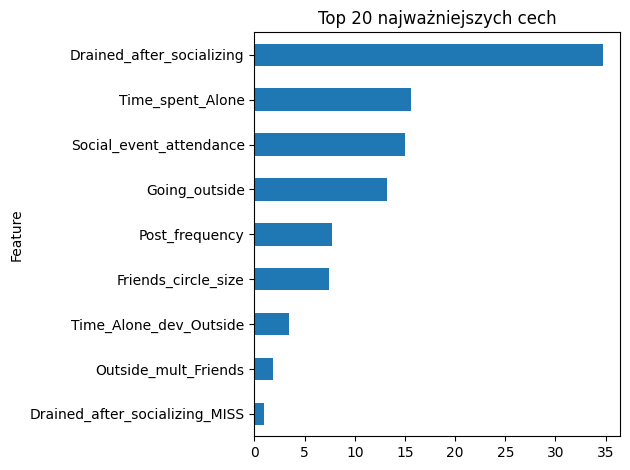

0:	learn: 0.6274485	total: 165ms	remaining: 49.3s
100:	learn: 0.1228231	total: 6.8s	remaining: 13.4s
200:	learn: 0.1186314	total: 14.2s	remaining: 6.99s
299:	learn: 0.1154412	total: 21.6s	remaining: 0us
0:	learn: 0.6313785	total: 66.6ms	remaining: 19.9s
100:	learn: 0.1216713	total: 7.99s	remaining: 15.7s
200:	learn: 0.1175562	total: 15.2s	remaining: 7.5s
299:	learn: 0.1142143	total: 22.3s	remaining: 0us
0:	learn: 0.6274485	total: 106ms	remaining: 26.5s
100:	learn: 0.1228231	total: 7.44s	remaining: 11s
200:	learn: 0.1186314	total: 14.8s	remaining: 3.6s
249:	learn: 0.1170367	total: 18.2s	remaining: 0us
0:	learn: 0.6276444	total: 69.5ms	remaining: 17.3s
100:	learn: 0.1247388	total: 6.65s	remaining: 9.82s
200:	learn: 0.1210906	total: 13.5s	remaining: 3.29s
249:	learn: 0.1196241	total: 16.7s	remaining: 0us
0:	learn: 0.6313785	total: 86.5ms	remaining: 21.5s
100:	learn: 0.1216713	total: 7.12s	remaining: 10.5s
200:	learn: 0.1175562	total: 14.5s	remaining: 3.53s
249:	learn: 0.1159433	total: 18.

In [128]:

# Wyciągnięcie ważności cech
#importances = best_model.get_feature_importance(Pool(train_df.drop(['id','Personality'], axis=1), train_df['Personality']))
feature_names = X.columns

# DataFrame z ważnościami
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wyświetlenie najważniejszych cech
plt.figure(figsize=(10, 6))
fi_df.head(20).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 najważniejszych cech")
plt.tight_layout()
plt.show()

## Optuna

In [ ]:
import optuna
from catboost import CatBoostClassifier

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "iterations": 500,
        "verbose": 0,
        "loss_function": "Logloss"
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_valid)[:,1]
    return roc_auc_score(y_valid, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params